In [2]:
import nidaqmx
from nidaqmx.constants import Edge, AcquisitionType
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

C:\Users\jlab\anaconda3_new_install\envs\rf_scope\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


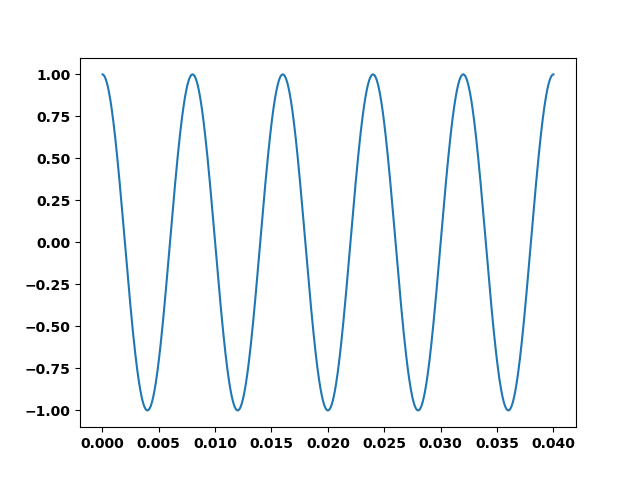

In [97]:
%matplotlib widget
sample_freq = 50000 
duration = 10 #in s
n_samples = duration * sample_freq
data = np.zeros((n_samples,1))
time = np.linspace(1/sample_freq, duration, n_samples)
wf_amp = 1
wf_freq = int(1000/8) # in Hz
# wf_saw = signal.sawtooth(wf_freq*time*(2*np.pi), 0.5)*wf_amp
# # b, a = signal.butter(2, 1000/(sample_freq/2), btype='low')
# sos = signal.butter(2, 2000/(sample_freq/2), btype='low', output='sos')
# wf_saw = signal.sosfiltfilt(sos, wf_saw)
# wf_saw = wf_saw.copy(order='C')
wf_sin = np.sin(wf_freq*time*(2*np.pi)+0.5*np.pi)*wf_amp
wf = wf_sin
plt.plot(time[0:5*sample_freq//wf_freq], wf[0:5*sample_freq//wf_freq])
# plt.plot(time, wf)

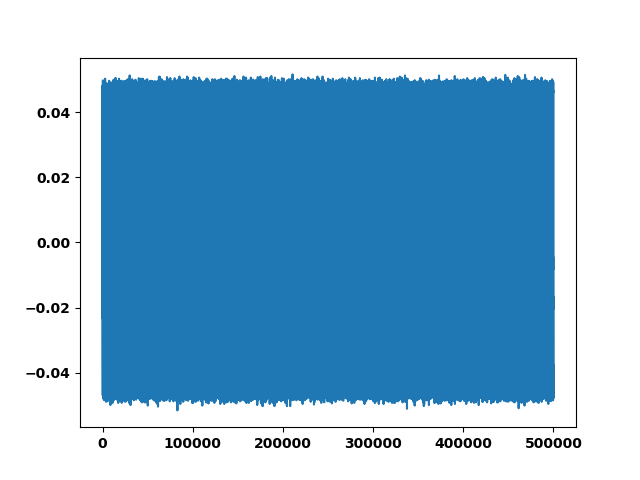

In [117]:
%matplotlib widget
samplesPerTrigger = sample_freq/wf_freq
with nidaqmx.Task() as outtask, nidaqmx.Task() as countertask, nidaqmx.Task() as intask:

    countertask.co_channels.add_co_pulse_chan_freq("Dev1/ctr0", freq=sample_freq)
    countertask.timing.cfg_implicit_timing(sample_mode=AcquisitionType.FINITE, samps_per_chan=int(samplesPerTrigger))
    countertask.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source="/Dev1/PFI1")
    countertask.triggers.start_trigger.retriggerable = True
        
        
    outtask.ao_channels.add_ao_voltage_chan("Dev1/ao1")
    outtask.timing.cfg_samp_clk_timing(
    sample_freq,
    source="/Dev1/Ctr0InternalOutput",
    active_edge=Edge.RISING,
    sample_mode=AcquisitionType.FINITE, samps_per_chan=n_samples)
    
    intask.ai_channels.add_ai_voltage_chan("Dev1/ai0:1")
    intask.timing.cfg_samp_clk_timing(sample_freq, source="", active_edge=Edge.RISING,
                                               sample_mode=AcquisitionType.FINITE,
                                               samps_per_chan=n_samples)
    intask.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source="/Dev1/PFI1")

    outtask.write(wf)
    outtask.start()
    intask.start()
    countertask.start()
    data = np.asarray(intask.read(n_samples, np.shape(wf)[0]/sample_freq + 10))
    
    # outtask.wait_until_done(np.shape(wf)[0]/sample_freq + 10)


# plt.plot(time[0:5*sample_freq//wf_freq],wf[0:5*sample_freq//wf_freq],
#           time[0:5*sample_freq//wf_freq], data[0:5*sample_freq//wf_freq])
plt.plot(data[1,:])

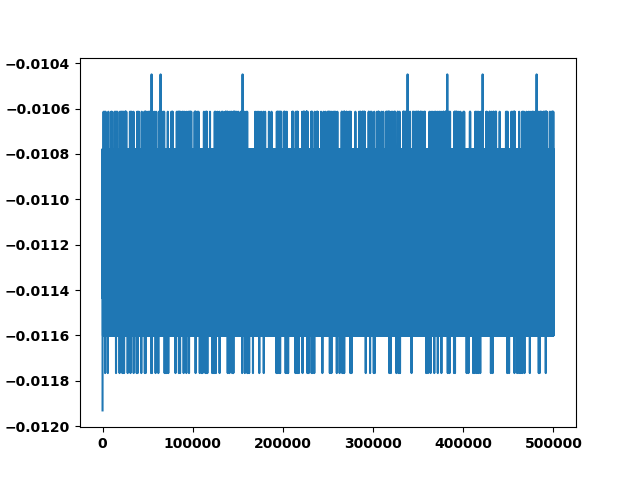

In [112]:
%matplotlib widget
plt.plot(data[1,:])
# data.shape

In [95]:
1000/8

125.0